# Simple linear regression demo

__Stephen David__

* Demonstrate basic methodologies for estimation of encoding models using a "toy",
  two-dimensional input space in Python

* Input is Gaussian white noise, which can contain correlations between channels,
  mimicking the correlations that occur in natural sounds. (set correlated_inputs=True)

* The output can pass through a static nonlinearity, illustrating limitations of
  a completely linear model, especially in generalizing to stimuli outside of the
  space used for fitting. (set output_nonlinearity=True)

Load the relevant libraries for analysis and plotting. 
* Note that strflib is not a native python library. It is a python file located in this working directory that contains useful functions for this analysis. This is a nice way to store useful functions that you find yourself using often during your analyses.

In [88]:
a=2
print('hello world')

hello world


In [70]:
print(a)

2


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import strflib  # some functions that support this notebook page

## Simulate data

`simulate_simple_data` generates (input=$x$, output=$y$) data for a simple system with two inputs. $x$ could be some experimentally controlled manipulations of a system, and $y$ could be any signal measured from that system. Our goal is to identify if and how $x$ influences $y$. Our model is:

$y = x(1) * h(1) + x(2) * h(2) + y_0$

$x$ is gaussian noise, with properties specified by optional parameters

$h(1)$ and $h(2)$ are weights applied to each input before summing to produce the output. $y_0$ is a constant baseline indicating the value of $y$ when $x=(0,0)$.

In [90]:
# define global variables for the simulated data

# parameters of static NL (if used)
sigmoid_parms=np.array([-1, 2.5, 0.5, 0.2])

def simulate_simple_data(h1=np.array([[0.5],[0]]), h0=np.zeros([1,1]), T=200,
                         correlated_inputs=False, output_nonlinearity=False, noise_amplitude=0.5,shifted_mean=False):
    """
    generate data for a cartoon model system
    :param h1:  N x 1 array - weights for each of N input channels
    :param h0:  1 x 1 array - baseline output
    :param T:   number of samples (recommend dimcount*T, where dimecount=h1.shape[0])
    :param correlated_inputs: should input channels be correlated?
    :param output_nonlinearity: static nonlinearity at output?
    :param noise_amplitude: how much noise (unpredictable activity) is present in the output
    :param shifted_mean: add a constant value to inputs (for messing with output nonlinearity effects)
    :return: 
      (x,y) tuple of simulated (input,output), dimensionality len(h1) X T 
 
    """
    # number of samples for estimation/testing
    dimcount=len(h1)  # ie, two input channels

    T=dimcount*100

    if shifted_mean:
        # mean of input -- shifted for the "out of class" test set
        m=np.matrix([[3],[3]])
        if correlated_inputs:
            s=np.array([[0.4, 0.1], [0.1, 0.4]])
        else:
            s=np.array([[1.0,0],[0,1.0]])
    else:
        # mean of input
        m=np.zeros([dimcount,1])
        
        if correlated_inputs:
            # gaussian noise stimulus covariance matrix has non-zero off-diagonal terms
            s=np.array([[1.0, 0.7], [0.7, 1.0]])
        else:
            # gaussian noise stimulus covariance matrix has zero off-diagonal terms
            s=np.array([[1.0, 0], [0, 1.0]])
    
    # Generate the input and pass it through the linear filter based on above parameters
    x=strflib.gnoise(m,s,T)

    # linear filter
    y=np.matmul(h1.T,x)

    if output_nonlinearity:
        # pass output of filter through sigmoid (if specified)
        y=strflib.logsig_fn(sigmoid_parms,y)

    if noise_amplitude:
        # add noise (if specified)
        # gaussian additive noise
        y=y+strflib.gnoise(np.zeros([1,1]),np.matrix([[noise_amplitude]]),T)

    return x,y


## Generate data without noise

True model: $y = 0.5 * x_1 + 0 * x_2$ generated deterministically for each $x$, $x$ is Gaussian white noise

In [92]:
h1=np.array([[0.6],[0]])
h0=np.zeros([1,1])
T=len(h1)*100

(x,y)=simulate_simple_data(h1, h0, T, correlated_inputs=False, output_nonlinearity=False, noise_amplitude=0.0,shifted_mean=False)
print("x size: {0}".format(x.shape))
print("y size: {0}".format(y.shape))

print("weights applied to input: h[0]={0}, h[1]={1}".format(h1[0,0],h1[1,0]))

x size: (2, 200)
y size: (1, 200)
weights applied to input: h[0]=0.6, h[1]=0.0


Plot the data as a time series. Note that the output y tracks the first input

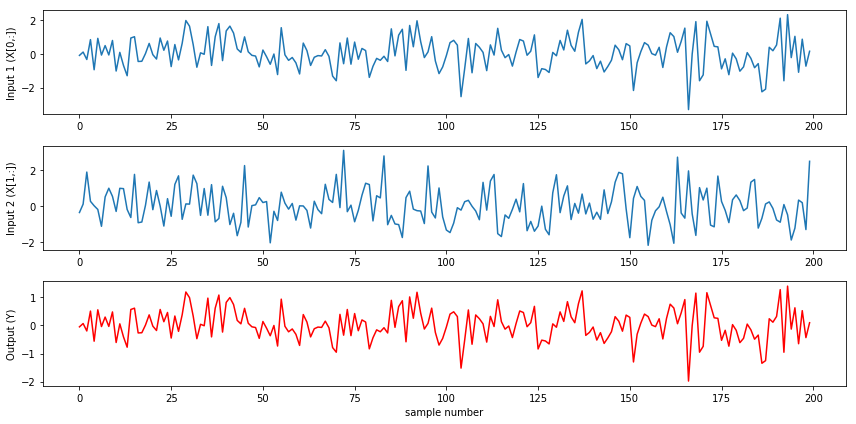

In [93]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(x[0,:])
plt.ylabel('Input 1 (X[0,:])')

plt.subplot(312)
plt.plot(x[1,:])
plt.ylabel('Input 2 (X[1,:])')

plt.subplot(313)
plt.plot(y[0,:],'r')
plt.ylabel('Output (Y)')
plt.xlabel('sample number')

plt.tight_layout()
plt.show()

While these data might be collected in a specific order, linear regression doesn't care about the sampling order. For regression, often you would plot this same data using a scatter plot.

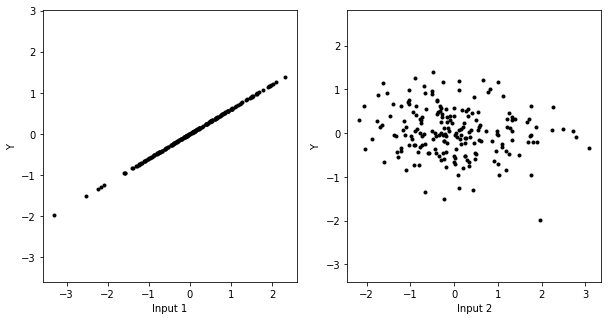

In [94]:
# Plot the data in scatter plots
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x[0,:],y[0,:],'k.')
plt.xlabel('Input 1')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x[1,:],y[0,:],'k.')
plt.axis('equal')
plt.xlabel('Input 2')
plt.ylabel('Y')

plt.tight_layout
plt.show()

## Generate a simple data set with noise

Data: $y = 0.5 * x_1 + 0 * x_2 + e(t)$ where $e(t) \propto N(\mu=0, \sigma=0.5)$

(No stimulus correlations, linear filter response, noise_amplitude=0.5)


In [95]:
(x_fit,y_fit)=simulate_simple_data(h1, h0, T, correlated_inputs=False, output_nonlinearity=False, noise_amplitude=0.5,shifted_mean=False)
print("fit data input (x_fit) size: {0}".format(x_fit.shape))
print("fit data output (y_fit) size: {0}".format(y_fit.shape))

fit data input (x_fit) size: (2, 200)
fit data output (y_fit) size: (1, 200)


Note that the relationship between x and y is less clear now, especially in the time series plot.

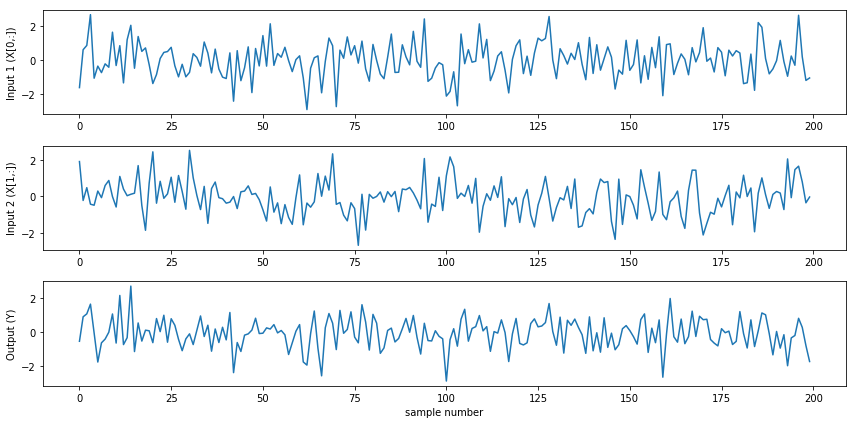

In [96]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(x_fit[0,:])
plt.ylabel('Input 1 (X[0,:])')

plt.subplot(312)
plt.plot(x_fit[1,:])
plt.ylabel('Input 2 (X[1,:])')

plt.subplot(313)
plt.plot(y_fit[0,:])
plt.ylabel('Output (Y)')
plt.xlabel('sample number')

plt.tight_layout()
plt.show();

But you can still see the relationship in the scatter plots

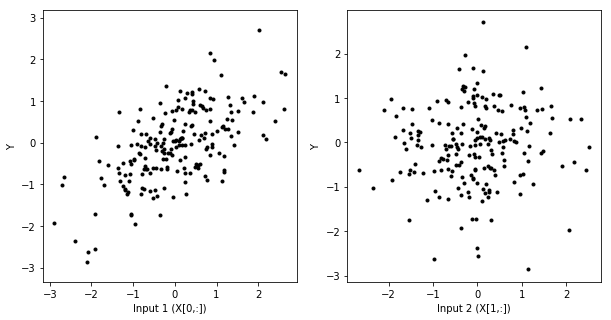

In [97]:
# STA results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x_fit[0,:],y_fit[0,:],'k.')
plt.xlabel('Input 1 (X[0,:])')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_fit[1,:],y_fit[0,:],'k.')
plt.axis('equal')
plt.xlabel('Input 2 (X[1,:])')
plt.ylabel('Y')

plt.tight_layout
plt.show()

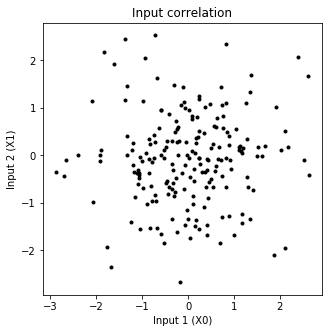

In [98]:
# plot X0 vs. X1 to illustrate stimulus autocorrelation (if specified)
plt.figure(figsize=(5,5))
plt.plot(x_fit[0,:],x_fit[1,:],'k.')
plt.xlabel('Input 1 (X0)')
plt.ylabel('Input 2 (X1)')
plt.title('Input correlation')
plt.show()

## First principles way to fit the model. Determine the filter that acted on the gaussian noise input to create the response above. Plot using basic matplotlib routines.

In [99]:
# subtract mean from stimulus and response to make data well-behaved
mx=np.mean(x_fit,axis=1)
my=np.mean(y_fit,axis=1)
xx=x_fit-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=y_fit-my

# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

print('estimated weights (h0,h1) : {:.4f}, {:.4f}'.format(hsta[0,0], hsta[1,0]))

estimated weights (h0,h1) : 0.5290, 0.0596


In [100]:
# slope of true underlying system
xr=np.array([[np.min(x_fit[0,:])],[np.max(x_fit[0,:])]])
yr0=xr * h1[0,0] + h0
yr1=xr * h1[1,0] + h0

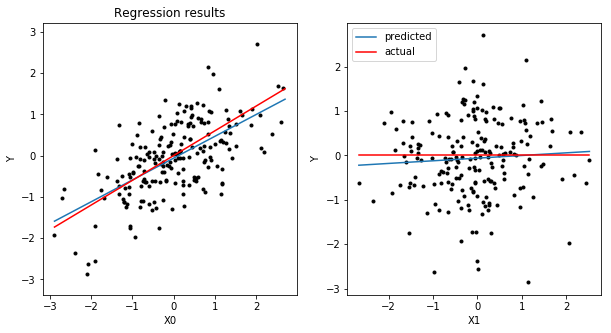

In [101]:
# Plot regression results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x_fit[0,:],y_fit[0,:],'k.')
xr=np.array([[np.min(x_fit[0,:])],[np.max(y_fit[0,:])]])
yr=xr * hsta[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('Regression results')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_fit[1,:],y_fit[0,:],'k.')
xr=np.array([[np.min(x_fit[1,:])],[np.max(x_fit[1,:])]])
yr=xr * hsta[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred, actual])
plt.axis('equal')
plt.tight_layout
plt.show()

## Or use built-in linear regression to do it

The `statsmodels` library is often used for this sort of problem. 

In [102]:
import statsmodels.api as sm

y = y_fit.T  #transpose the output data matrix to match expected format
X = x_fit.T  #transpose the input data matrix to match expected format

# Create and fit a model in one line:
model = sm.OLS(y, X).fit()

# Print out the a summary of the model fit results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.388
Model:                            OLS   Adj. R-squared (uncentered):              0.382
Method:                 Least Squares   F-statistic:                              62.84
Date:                Thu, 12 Sep 2019   Prob (F-statistic):                    7.37e-22
Time:                        11:24:36   Log-Likelihood:                         -209.44
No. Observations:                 200   AIC:                                      422.9
Df Residuals:                     198   BIC:                                      429.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5277      0.047     11.141      0.000       0.434       0.621
x2             0.0427      0.051      0.835      0.405      -0.058       0.144
==============================================================================
Omnibus:                        0.260   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.411
Skew:                          -0.042   Prob(JB):                        0.814
Kurtosis:                       2.795   Cond. No.                         1.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

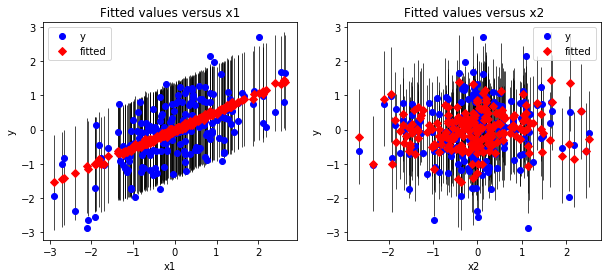

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
sm.graphics.plot_fit(model, 0, ax=axs[0]);
sm.graphics.plot_fit(model, 1, ax=axs[1]);


## Example where inputs are correlated

In [85]:
# generate data with correlated_inputs=True
T=400
(x_cor,y_cor)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=False, noise_amplitude=0.5,shifted_mean=False)


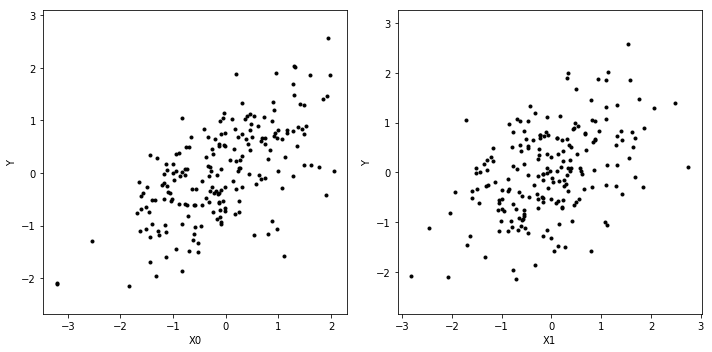

In [86]:
# Plot data where inputs (X0 and X1) are correlated
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
plt.xlabel('X1')
plt.ylabel('Y')
plt.axis('equal')
plt.tight_layout()
plt.show()

Try simple reverse correlation

In [87]:
# subtract mean from stimulus and response to make data well-behaved
mx=np.mean(x_cor,axis=1)
my=np.mean(y_cor,axis=1)
xx=x_cor-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=y_cor-my

# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

print("hsta={0}".format(hsta))

ValueError: operands could not be broadcast together with shapes (2,200) (2,400) 

In [ ]:
# STA results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[0,:])],[np.max(y_cor[0,:])]])
yr=xr * hsta[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('STA')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[1,:])],[np.max(x_cor[1,:])]])
yr=xr * hsta[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# plot X0 vs. X1 to illustrate stimulus autocorrelation (if specified)
plt.figure(figsize=(3,3))
plt.plot(x_cor[0,:],x_cor[1,:],'k.')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Input correlation')
plt.show()

In [ ]:
# estimate filter using normalized reverse correlation (aka linear regression)
Cinv=np.linalg.inv(C)
hnrc= np.matmul(Cinv, SR)

print("hnrc={0}".format(hnrc))

In [ ]:
# NRC results
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[0,:])],[np.max(y_cor[0,:])]])
yr=xr * hnrc[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('Norm RC')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[1,:])],[np.max(x_cor[1,:])]])
yr=xr * hnrc[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# estimate filter using coordinate descent (aka boosting)
(hcd,hcd0)=strflib.coordinate_descent(x_cor,y_cor,0)

In [ ]:
# Coordinate descent results
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[0,:])],[np.max(y_cor[0,:])]])
yr=xr * hcd[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('Coordinate descent')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[1,:])],[np.max(x_cor[1,:])]])
yr=xr * hcd[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout()
plt.show()

## Nonlinear system

In [ ]:
# parameters of static NL (if used)
sigmoid_parms=np.array([-1, 3, 0.75, 0.1])

(x_nl,y_nl)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=True, noise_amplitude=0.05,shifted_mean=False)
(x_out,y_out)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=True, noise_amplitude=0.05,shifted_mean=True)


In [ ]:
# subtract mean from stimulus and response to make data well-behaved
mx=np.mean(x_nl,axis=1)
my=np.mean(y_nl,axis=1)
xx=x_cor-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=y_cor-my

# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

print("hsta={0}".format(hsta))

# estimate filter using normalized reverse correlation (aka linear regression)
Cinv=np.linalg.inv(C)
hnrc= np.matmul(Cinv, SR)

print("hnrc={0}".format(hnrc))


In [ ]:
# NRC results
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x_out[0,:],y_out[0,:],'r.')
plt.plot(x_nl[0,:],y_nl[0,:],'k.')
xr=np.array([[np.min(x_nl[0,:])],[np.max(x_out[0,:])]])
yr=xr * hnrc[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
#plt.plot(xr,yr0,'r-')
plt.title('NRC')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_out[0,:],y_out[0,:],'r.')
plt.plot(x_nl[1,:],y_nl[0,:],'k.')
xr=np.array([[np.min(x_nl[1,:])],[np.max(x_out[1,:])]])
yr=xr * hnrc[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
#actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred])
plt.axis('equal')
plt.tight_layout()
plt.show()

Compare error for "in" vs. "out" data

In [ ]:
my=np.mean(y_nl)
predicted_nl=np.matmul(hnrc.T,x_nl)+my
predicted_out=np.matmul(hnrc.T,x_out)+my

error_nl=np.square(y_nl-predicted_nl)
error_out=np.square(y_out-predicted_out)
me_nl=np.mean(error_nl)
me_out=np.mean(error_out)

print("Mean squared error in={0} out={1}".format(me_nl,me_out))


## Spiking nonlinearity

In [ ]:
# parameters of static NL (if used)
sigmoid_parms=np.array([-1, 3, 0.75, 0.1])

(x_nl,y_nl)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=True, noise_amplitude=0.05,shifted_mean=False)
(x_out,y_out)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=True, noise_amplitude=0.05,shifted_mean=True)


In [ ]:
import seaborn

In [ ]:
def logsig_fn(phi,X):
    """
    sigmoid function
    static nonlinearity from Rabinowitz et al 2011
    """
    a=phi[0]   # baseline
    b=phi[1]   # asymptote
    c=phi[2]   # inflection point
    d=phi[3]   # slope
    Y=a+b/(1+np.exp(-(X-c)/d))
    return(Y)